In [1]:
import torch
import os
import random
import utils
import data_utils
import json

import cbm
import plots

In [2]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "./saved_models/covid_cbm_2024_03_21_05_03"
device = "cuda"
'''
{
  "clip_name": "ViT-B/16",
  "backbone": "vit",
  "device": "cuda",
  "batch_size": 16,
  "saga_batch_size": 256,
  "dataset": "ham10000",
  "concept_set": "data/concept_sets/ham10000_filtered_new.txt",
  "feature_layer": "norm",
  "activation_dir": "saved_activations",
  "save_dir": "saved_models",
  "clip_cutoff": 0.25,
  "proj_steps": 1000,
  "interpretability_cutoff": 0.45,
  "lam": 0.0007,
  "n_iters": 1000
}
'''
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
print(args)
dataset = args["dataset"]

val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]



with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")
    
num_classes = len(classes)
    
_, target_preprocess = data_utils.get_target_model(args["backbone"], device, dataset, num_classes)
model = cbm.load_cbm(load_dir, device, dataset, num_classes)

{'clip_name': 'ViT-B/16', 'backbone': 'vit', 'device': 'cuda', 'batch_size': '16', 'saga_batch_size': '256', 'dataset': 'covid', 'concept_set': 'data/concept_sets/covid_filtered_new.txt', 'feature_layer': 'norm', 'activation_dir': 'saved_activations', 'save_dir': 'saved_models', 'clip_cutoff': '0.21', 'proj_steps': '20000', 'interpretability_cutoff': '0.15', 'lam': '7e-05', 'n_iters': '10000'}
768


In [3]:
val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

## Measure accuracy

In [4]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device, dataset_name = args["dataset"])
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 21/21 [00:14<00:00,  1.45it/s]

Accuracy: 80.69%


## Show final layer weights for some classes

In [5]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in range(len(classes)):
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:0 - covid
Incoming weights:
a bronchiole [0.0377] covid
air trapping [0.0295] covid
areas of consolidation [0.0151] covid
bilateral [0.0024] covid
consolidation [0.0173] covid
ground glass [0.0311] covid
infection [0.0296] covid
mediastinal [0.0080] covid
microorganism [0.0421] covid
no consolidation or collapse [0.0417] covid
no evidence of air trapping [0.0368] covid
no lesions [0.0319] covid
no nodules or masses [0.0118] covid
no pleural effusion [-0.0048] covid
nodular lesions [-0.0084] covid
not disease [0.0003] covid
not virus [0.0375] covid
pathogen [0.0131] covid
peripheral [0.0444] covid
Output class:1 - noncovid
Incoming weights:
a bronchiole [-0.0124] noncovid
air trapping [-0.0590] noncovid
areas of consolidation [-0.0089] noncovid
bilateral [-0.0547] noncovid
consolidation [-0.0158] noncovid
ground glass [-0.0240] noncovid
infectious agent [-0.0094] noncovid
lungs are clear [-0.0427] noncovid
microorganism [-0.0052] noncovid
no consolidation or collapse [-0.04

## Explain model reasoning for random inputs

torch.Size([2, 797])


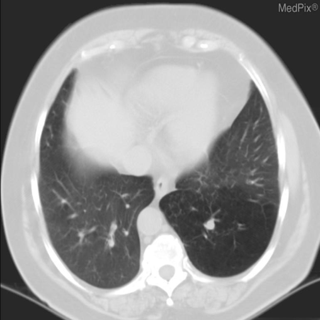

tensor([ 5.3039, -4.8983], device='cuda:0') tensor([1, 0], device='cuda:0')
tensor([3.7085e-05, 9.9996e-01], device='cuda:0')
Image:229 Gt:noncovid, 1st Pred:noncovid, 5.304, 2nd Pred:covid, -4.898
torch.Size([797])


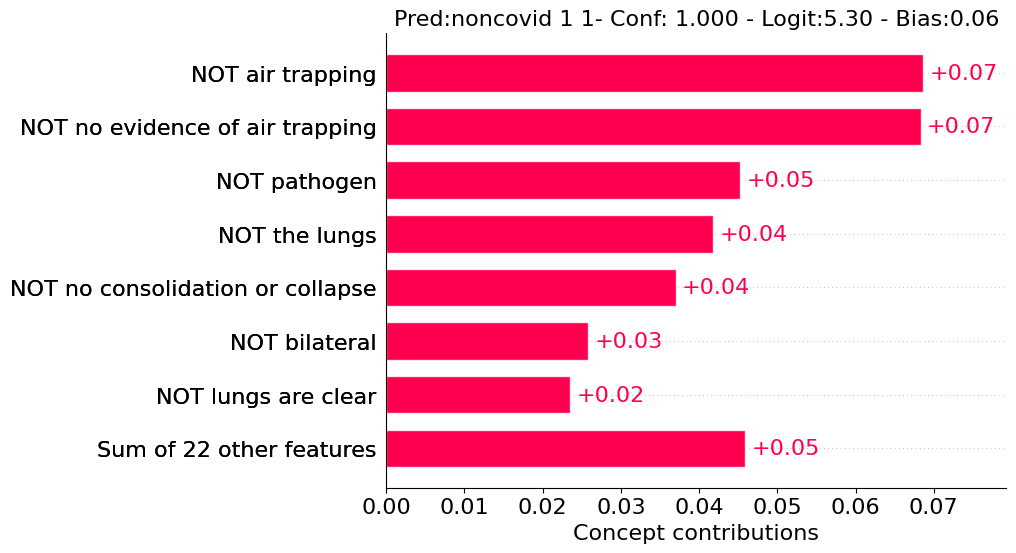

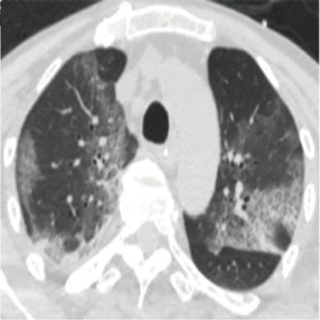

tensor([ 4.2626, -4.0248], device='cuda:0') tensor([1, 0], device='cuda:0')
tensor([2.5162e-04, 9.9975e-01], device='cuda:0')
Image:252 Gt:noncovid, 1st Pred:noncovid, 4.263, 2nd Pred:covid, -4.025
torch.Size([797])


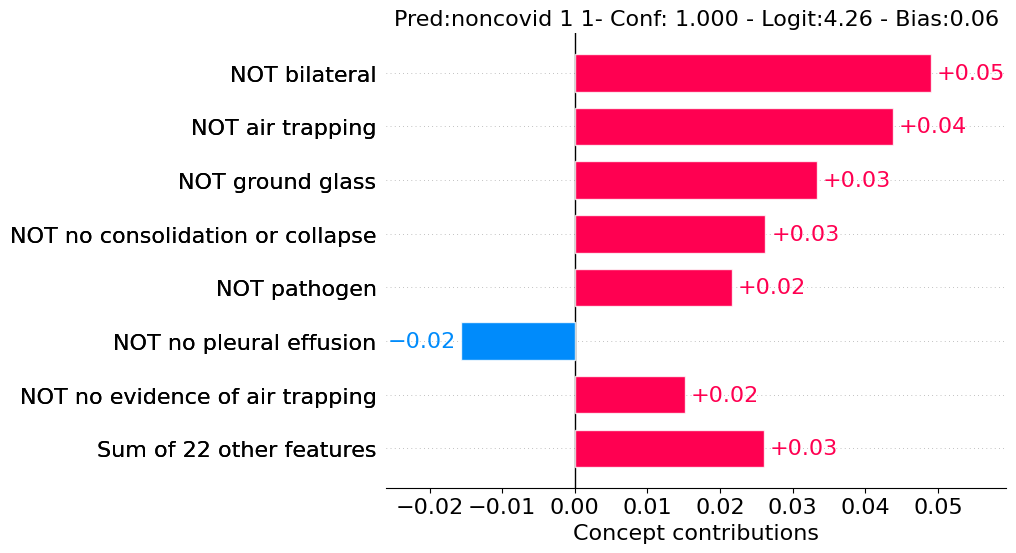

In [12]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=2)
print(model.final.weight.shape)
with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        print(top_logit_vals, top_classes)
        
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print(conf)
        
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        

        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            print(contributions.shape)
            contributions = contributions[:len(concepts)]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.000))+1, 8)
            title = "Pred:{} {} {}- Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],top_classes[k],label,
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)